In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.greed_optimize import greed_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import cPickle

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


In [2]:
with open('./results_cv_mad.pckl', 'rb') as inp:
    mad = cPickle.load(inp)
with open('./results_cv_rand.pckl', 'rb') as inp:
    rand = cPickle.load(inp)    
with open('./results_cv_greed.pckl', 'rb') as inp:
    greed = cPickle.load(inp)
with open('./results_cv_hoag.pckl', 'rb') as inp:
    hoag = cPickle.load(inp)


#X_train, X_test = np.load('../../../data/W_X_Tr.npy'), np.load('../../../data/W_X_Test.npy')
#Y_train, Y_test = np.load('../../../data/W_Y_Tr.npy'), np.load('../../../data/W_Y_Test.npy')

test_size=20
X_train = np.load('../../../data/linear2_x.npy').astype(theano.config.floatX)[:test_size]
Y_train = np.load('../../../data/linear2_y.npy').astype(theano.config.floatX)[:test_size]

X_test = np.load('../../../data/linear2_x.npy').astype(theano.config.floatX)[test_size:]
Y_test = np.load('../../../data/linear2_y.npy').astype(theano.config.floatX)[test_size:]
bias,var = np.load('../../../data/linear2_bias_var.npy')

X = np.arange(-2, 2, 0.1)
XX = np.vstack([ X,np.ones(X.shape[0]), X**2, X**3, X**4, X**5, X**6, X**7, X**8, X**9,  np.cos(X), np.sin(X)])
XX = XX.T
XX = (XX-bias)/var
XX[:,1] =  np.ones(X.shape[0])
XX = np.vstack([ XX.tolist(), X_train.tolist() , X_test.tolist()])

XX=np.array(sorted(XX.tolist(), key=lambda x:x[0])) 


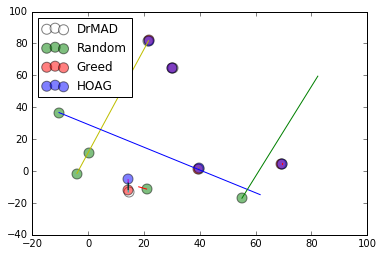

In [14]:
#plt.matshow(matrix.T)
for dataset, label, c in [(mad, 'DrMAD', 'w'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                        ]:
    first = True
    for i in dataset:
        first_value = i.history[0][0][0]
        i = i.best_values[0]
        
        first_value = np.log10(np.exp(2*first_value))*10
        i = np.log10(np.exp(2*i))*10
        if first:
            plt.scatter(i[0] + np.random.randn(1)*0.1,i[1]+ np.random.randn(1)*0.1, c=c, label=label, alpha=0.5, s=100)
            first = False
        else:
            plt.scatter(i[0]+ np.random.randn(1)*0.1,i[1]+ np.random.randn(1)*0.1, c=c, alpha=0.5, s=100)
        #print [first_value[0], i[0]],[first_value[1], i[1]]
        plt.plot([first_value[0], i[0]],[first_value[1], i[1]])
        
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (20,20)
#plt.scatter(2713%100 ,2713/100, s=1000)


DrMAD
DrMAD
DrMAD
DrMAD
DrMAD
DrMAD
-174.143744071
std [ 5.75249957  5.73997626  5.73000248  5.72248834  5.71719238  5.71378532
  5.71191221  5.71123936  5.71148172  5.71241343  5.71379223  5.71529704
  5.71695487  5.71879985  5.72087489  5.72323343  5.72594056  5.72907278
  5.73271442  5.7369482   5.7418374   5.74739919  5.75357484  5.76021127
  5.76707139  5.77387912  5.78038169  5.78639855  5.7918378   5.7966834
  5.80096955  5.80475612  5.80811112  5.81110064  5.81378409  5.81621269
  5.81842953  5.8204705   5.82236532  5.82413859  5.82581078  5.82739897
  5.82891752  5.83037863  5.83179273  5.83316883  5.83451482  5.83583763
  5.8371435   5.83843803  5.83843803]
Random
Random
Random
Random
Random
Random
-171.686993537
std [ 2.52810749  2.5042752   2.5042752   2.22909846  2.23298195  2.23298195
  2.23481731  2.23481731  2.23481731  2.26815154  2.27147602  2.27147602
  2.2312481   2.2312481   2.2312481   2.35989268  2.35989268  2.35989268
  2.35989268  2.35989268  2.35989268  2.3598

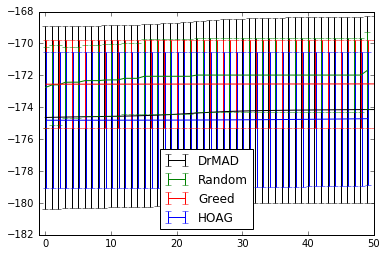

In [3]:
id = -1
for dataset, label, c in [(mad, 'DrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    for b in dataset:
        print label
        
        history = []
        for i in xrange(0, len(b.history)):
        
            best_value = max([h[1] for h in b.history[:i+1]])
            
            history.append(best_value)
        line.append(history)
    print label
    print np.mean(line, axis=0)[-1]
   
    #plt.fill_between(range(len( np.mean(line, axis=0))),  np.mean(line, axis=0)-np.std(line, axis=0), np.mean(line, axis=0)+np.std(line, axis=0), facecolor=c, alpha=0.25 )
    print 'std', np.std(line, axis=0)
    plt.errorbar(np.array(range(len(line[0])))+id*0.25/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    #plt.plot( np.mean(line, axis=0), label=label, c=c, lw=3)
#plt.ylim((-1000000, -1160000))
plt.xlim((-1,50))
plt.legend(loc='best')


DrMAD
1.40333
Random search
1.36732
Greedy algorithm
1.42186
HOAG
1.43211


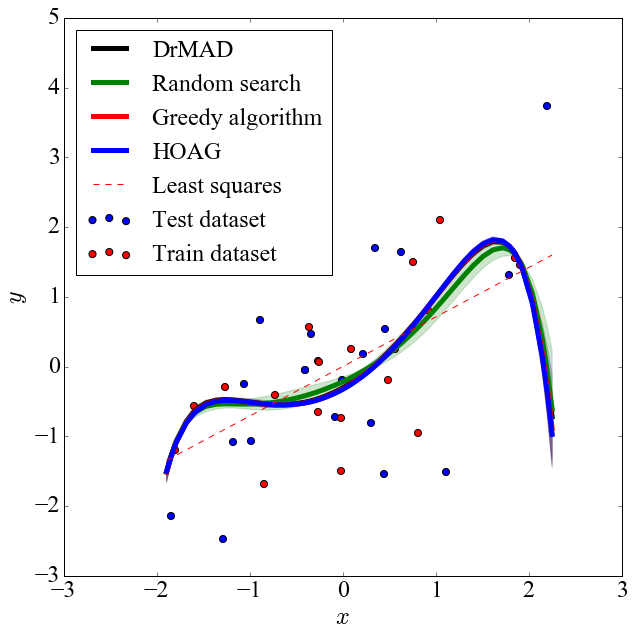

In [4]:
from matplotlib import rc
font = {'family': 'Times New Roman',
        'weight': 'normal',
       'size':24}
rc('font', **font)
plt.xlabel('$x$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
plt.rcParams['figure.figsize'] = (10, 10)


id = -1

inits = [0.0]
param_num = X_train.shape[1]
alphas = theano.shared(np.array([1.0]*param_num).astype(theano.config.floatX))
lr = theano.shared(np.array(7.5*10**(-3)).astype(theano.config.floatX))

optimizer = partial(gd_optimizer, learning_rate=lr)

model_build = partial(build_feedforward,  use_softmax=False,  structure = [X_train.shape[1], 1],   init_sigmas=inits, nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
tc = simple_tc(model_build, optimizer,X_train, Y_train, batch_size=test_size)
optimizer = partial(gd_optimizer, learning_rate=lr)

for dataset, label, c in [(mad, 'DrMAD', 'k'), 
                         (rand, u'Random search', 'g'),
                         (greed, u'Greedy algorithm', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    print label
    poly = []
    errs = []
    for b in dataset:
        for m in tc.models:
            m.respawn()
        
        
        
        alphas.set_value(np.array(b.best_values[0]).astype(np.float32))
        
        for _ in xrange(1000):
            res = tc.do_train()
        params = tc.models[0].params.eval()[:12]
        
        poly.append(np.dot(XX,  np.array(params )))
        errs.append(np.sqrt(np.mean((np.dot(X_test,  params ) -  Y_test)**2)))
    mean = np.mean(poly, axis=0)
    err=  np.std(poly, axis=0)
    plt.fill_between(XX[:,0], mean-err, mean+err, color=c, alpha=0.2)
    plt.plot(XX[:,0], mean, c=c, label=label, lw='5')
    print np.mean(errs)
   


plt.plot(XX[:,0], 0.71* XX[:,0], lw=1, c='r', ls='--', label=u'Least squares')
plt.scatter(X_test[:,0], Y_test, label=u'Test dataset', s=50)
plt.scatter(X_train[:,0], Y_train, c='r', label=u'Train dataset', s=50)

plt.legend(loc='best', fontsize=24)
plt.savefig('../../../doc/plots/poly_cv.pdf')

#plt.title('Polynoms: Cross-Validation')

In [15]:
plt.__file__

'/usr/local/lib/python2.7/dist-packages/matplotlib/pylab.pyc'

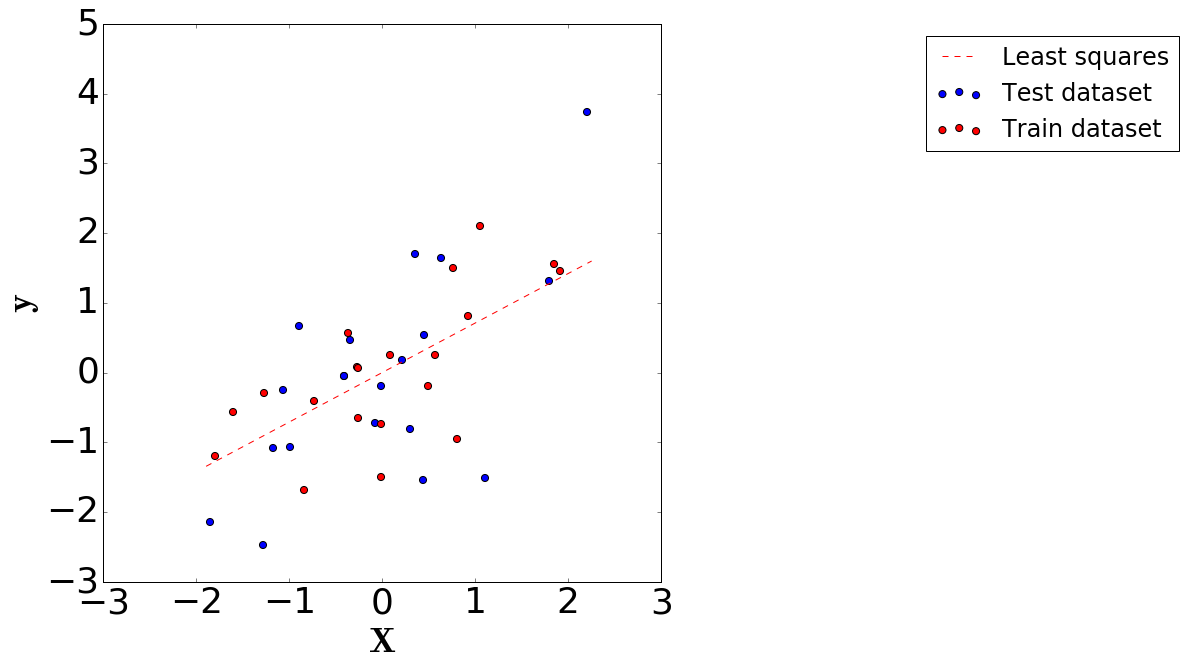

In [38]:
font = {'family': 'Times New Roman',
        'weight': 'normal',
       'size':36}
rc('font', **font)
plt.xlabel('$\mathbf{X}$', fontsize=36)
plt.ylabel('$\mathbf{y}$', fontsize=36)
plt.plot(XX[:,0], 0.71* XX[:,0], lw=1, c='r', ls='--', label=u'Least squares')
plt.scatter(X_test[:,0], Y_test, label=u'Test dataset', s=50)
plt.scatter(X_train[:,0], Y_train, c='r', label=u'Train dataset', s=50)

plt.legend(bbox_to_anchor=(1.95, 1.00), fontsize=24)

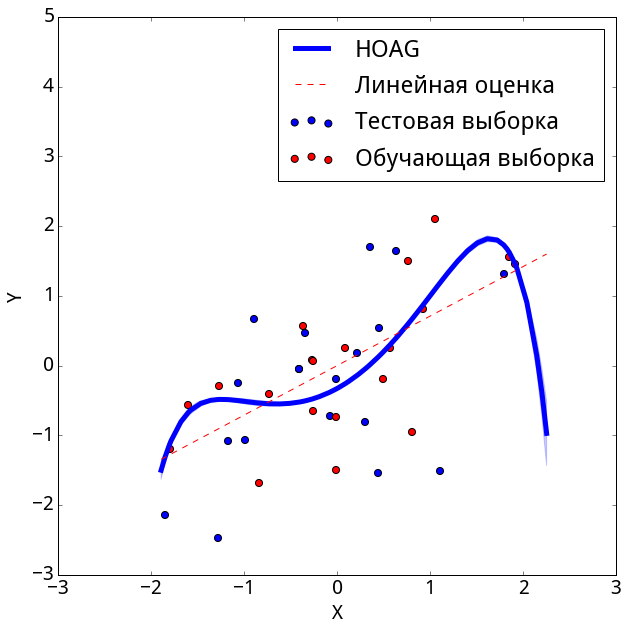

In [5]:
from matplotlib import rc
 
font = {'family': 'Droid Sans',
        'weight': 'normal',
       'size':20}
rc('font', **font)
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel(u'X', fontsize=20)
plt.ylabel(u'Y', fontsize=20)
plt.fill_between(XX[:,0], mean-err, mean+err, color=c, alpha=0.2)
plt.plot(XX[:,0], mean, c=c, label=label, lw='5')

   


plt.plot(XX[:,0], 0.71* XX[:,0], lw=1, c='r', ls='--', label=u'Линейная оценка')
plt.scatter(X_test[:,0], Y_test, label=u'Тестовая выборка', s=50)
plt.scatter(X_train[:,0], Y_train, c='r', label=u'Обучающая выборка', s=50)

plt.legend(loc='best')

In [ ]:
import theano.tensor as T
param_num = X_train.shape[1] * 50 + 50 + 50  + 1

lr = theano.shared(10**(-5))
alphas = theano.shared(np.array([1.0, 1.0]))
real_alphas = T.concatenate([T.repeat(alphas[0],  X_train.shape[1] * 50 + 50)   , T.repeat(alphas[1],  50 + 1) ])
optimizer = partial(gd_optimizer, learning_rate=lr)
inits = [np.sqrt(2.0/(X_train.shape[1] + 50)).astype(theano.config.floatX), np.sqrt(2.0/(50 + 1)).astype(theano.config.floatX)]

model_build = partial(build_feedforward,  structure = [X_train.shape[1],50, 1],   init_sigmas=inits, nonlinearity=lambda x:T.nnet.relu(x), log_alphas =real_alphas, bias=True)


training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=25 )



X_t = T.matrix()
result = []

predicts = []

for m in training_procedure.models:    
    predict = m.predict_var(X_t)
    predicts.append(theano.function([X_t], predict))
print 'start'
id = -1
for dataset, label, c in [#(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         #(greed, 'Greed', 'r'),
                         #(hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        
        for i in xrange(0, len(b.history), 10):
            
            best_value = np.argmax([h[1] for h in b.history[:i+1]])
            #print best_value
            best_value = b.history[best_value][0]
            # if i==len(b.history)-1:
            #     print best_value[0]

            alphas.set_value(best_value[0])
            #alphas.set_value(np.array([1.0, 1.0]))
         


            for tr in xrange(10000):
                res = training_procedure.do_train()
                if tr%1000 == 0:
                    print tr, res
            print training_procedure.do_validation()
            res = []
            res = np.sqrt(np.mean((predicts[0](X_test)[:,0]-Y_test)**2))
            
            history.append(res)
            
        line.append(history)
        


        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """

    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1, label=label)
    print  np.mean(line, axis=0)[-1], np.std(line, axis=0)[-1]
#plt.ylim((0.0, 0.1))
plt.legend(loc='best')
print history

start
Random
0 -1596159.4304
1000 -1595551.64663
2000 -1595555.97557
3000 -1595556.46432
4000 -1595556.35917
5000 -1595559.22239
6000 -1595558.02825
7000 -1595553.88683
8000 -1595558.23841
9000 -1595559.07986
-1595555.6609
0 -1493126.03056
1000 -1356358.50059
2000 -1356359.01795
3000 -1356360.29983
4000 -1356358.5854
5000 -1356362.37543
6000 -1356359.07208
7000 -1356356.08376
8000 -1356370.51671
9000 -1356362.73039
-1356360.26979
0 -1356257.79965
1000 -1356254.92875
2000 -1356260.43295
3000 -1356255.77099
4000 -1356257.42135
5000 -1356259.74499
6000 -1356257.56353
7000 -1356257.40945
8000 -1356254.90495


In [37]:
batch_size = 25
lr = theano.shared(10**(-5))
log_alphas = theano.shared(np.array([10.0]))

optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [X_train.shape[1], 50,   1],  init_sigmas=[0.001]*3,  nonlinearity=lambda x:T.nnet.relu(x), log_alphas=log_alphas, bias=True)
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,   batch_size=batch_size )
model = model_build(params=training_procedure.models[0].params, dataset_size=1)
X = T.matrix()
predict = theano.function([X], model.predict_var(X))

def mse(Y1, Y2):
    return np.sum((Y1 - Y2)**2)

#100 epochs, 2500/25 ~ 100 iterations
err = []
Y = predict(X_test)
err.append(mse(Y[:,0], Y_test))
for epoch in xrange(100):
    
    for i in xrange(100):
        training_procedure.do_train()
    
    Y = predict(X_test)
    err.append(mse(Y[:,0], Y_test))
    

    

<Container object of 3 artists>

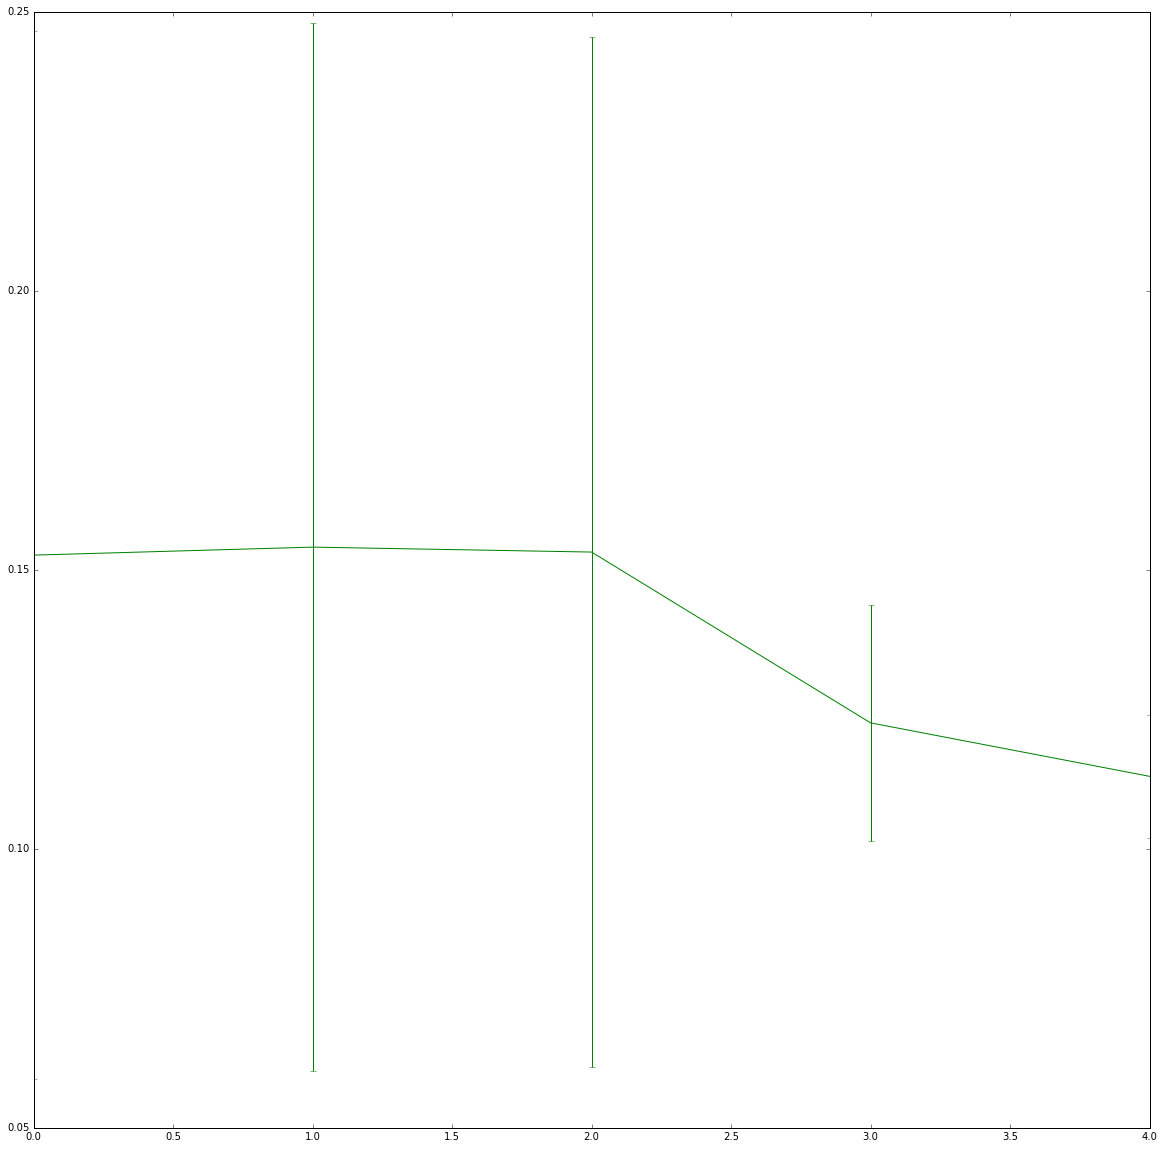

In [19]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):

            best_value = np.max([h[1] for h in b.history[:i+1]])
            history.append(best_value)
        history = np.array(history)
        history = history[-1]/history
        history = np.where(history>=0.99)[0]
       
        line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
    print np.mean(line), np.median(line), np.std(line)

MrMAD
16.7 2.0 19.3847878503
Random
16.0 16.0 11.2178429299
Greed
9.7 9.5 6.30634601017
HOAG
13.96 0.0 18.0032885885


[0,
 0,
 0,
 0,
 0,
 41,
 41,
 0,
 42,
 20,
 0,
 21,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 45,
 21,
 38,
 0,
 38,
 0,
 21,
 0,
 40,
 0,
 21,
 41,
 0,
 38,
 0,
 0,
 40,
 41,
 0,
 41,
 44,
 0,
 21,
 1,
 41]

In [18]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    history = []
    for b in dataset:
        best_value = np.max([h[1] for h in b.history])
        history.append(best_value)
    print label, np.mean(history), np.std(history)

MrMAD -84.3734550695 2.64868121711
Random -79.0795962452 0.579801774023
Greed -81.2431813983 2.55392428429
HOAG -83.769210776 2.88260320189


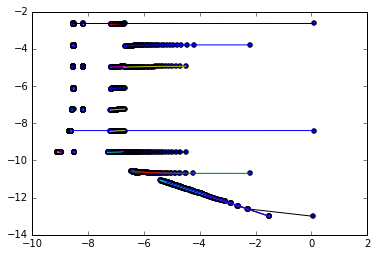

In [15]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(np.linalg.norm(np.exp(h[0][0]- np.array([2713%100, 2713/100]))))
    plt.scatter(np.log(X_),np.log(Y_))
    plt.plot(np.log(X_),np.log(Y_))

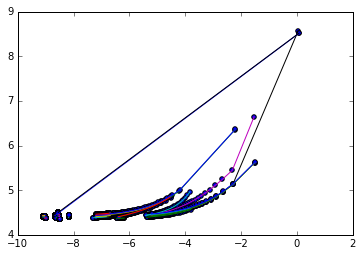

In [18]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(h[-1])
    plt.scatter(np.log(X_),np.log(-np.array(Y_)))
    plt.plot(np.log(X_),np.log(-np.array(Y_)))

In [8]:
Y_

[array(-277.29114686678855),
 array(-172.0529722751367),
 array(-144.604822027735),
 array(-130.54732451849281),
 array(-121.83425910611308),
 array(-115.85820765135955),
 array(-111.48760719898455),
 array(-108.14485094732697),
 array(-105.50206663098866),
 array(-103.35849231157151),
 array(-101.58397161486275),
 array(-100.0902594319505),
 array(-98.81532630205706),
 array(-97.71425190236292),
 array(-96.75368167212932),
 array(-95.90831490367741),
 array(-95.15860334906061),
 array(-94.48919871332782),
 array(-93.8878786398681),
 array(-93.34478712966856),
 array(-92.85188674876497),
 array(-92.40255664053902),
 array(-91.99129289576109),
 array(-91.61348205119077),
 array(-91.26522766886708),
 array(-90.94321600289554),
 array(-90.64461082999833),
 array(-90.3669703030455),
 array(-90.1081806203322),
 array(-89.8664026664511),
 array(-89.64002875450987),
 array(-89.42764730396243),
 array(-89.22801380386706),
 array(-89.04002679270404),
 array(-88.86270787075387),
 array(-88.69518

In [7]:
id = -1
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        
        #for i in xrange(len(b.history)):
        track = [h[1] for h in b.history]
        track = [t-track[0] for t in track]
        best = np.max(track)
        need_value = best*0.99
        track = np.where(track>=need_value)[0]
        line.append(np.min(track))
        #best_value = np.argmax([h[1] for h in b.history])
        #line.append(best_value)
        
        #history = np.array(history)
        
        #history = history[-1]/history
        
        #history = [history[i-1]/history[i] for i in range(1, len(history))]# history#np.where(history>=0.99)[0]
        
        #history = np.where(history>=0.99)[0]
        #line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
        
    print np.mean(line), np.std(line)

MrMAD
40.2 16.1418710192
Random
26.2 19.9939990997
Greed
30.0 24.4948974278
HOAG
29.4 24.0049994793


SIGMA IS 0.5
DrMAD
1.51178319747
Случайный поиск
1.5545604521
Жадный алгоритм
1.53560991468
HOAG
1.55350186432


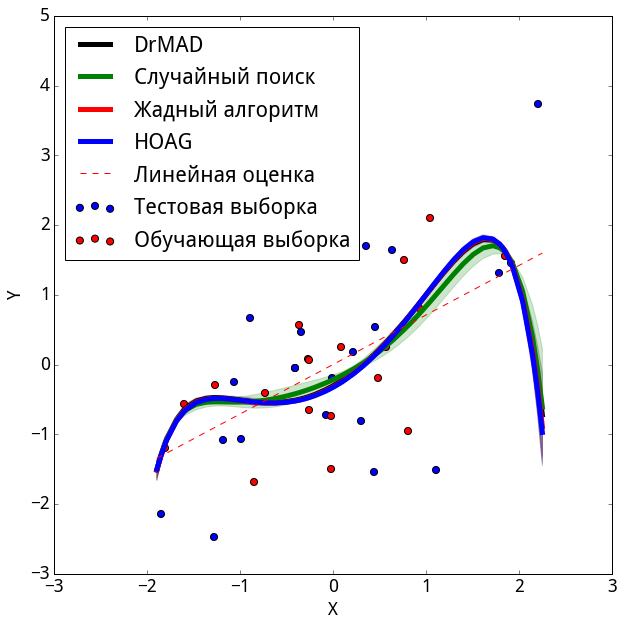

In [20]:
sigma = 0.5
print 'SIGMA IS', sigma
from matplotlib import rc
font = {'family': 'Droid Sans',
        'weight': 'normal',
       'size':18}
rc('font', **font)
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel(u'X', fontsize=18)
plt.ylabel(u'Y', fontsize=18)

id = -1

inits = [0.0]
param_num = X_train.shape[1]
alphas = theano.shared(np.array([1.0]*param_num).astype(theano.config.floatX))
lr = theano.shared(np.array(7.5*10**(-3)).astype(theano.config.floatX))

optimizer = partial(gd_optimizer, learning_rate=lr)

model_build = partial(build_feedforward,  use_softmax=False,  structure = [X_train.shape[1], 1],   init_sigmas=inits, nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
tc = simple_tc(model_build, optimizer,X_train, Y_train, batch_size=test_size)
optimizer = partial(gd_optimizer, learning_rate=lr)

for dataset, label, c in [(mad, 'DrMAD', 'k'), 
                         (rand, u'Случайный поиск', 'g'),
                         (greed, u'Жадный алгоритм', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    print label
    poly = []
    errs = []
    for b in dataset:
        for m in tc.models:
            m.respawn()
        
        
        
        alphas.set_value(np.array(b.best_values[0]).astype(np.float32))
        
        for _ in xrange(1000):
            res = tc.do_train()
        for _ in xrange(20):
            params = tc.models[0].params.eval()[:12]
            poly.append(np.dot(XX,  np.array(params).astype(np.float32) ))
            errs.append(np.sqrt(np.mean((np.dot(X_test + np.random.randn(*X_test.shape)*sigma,  np.array(params) ) -  Y_test)**2)))
    mean = np.mean(poly, axis=0)
    err=  np.std(poly, axis=0)
    plt.fill_between(XX[:,0], mean-err, mean+err, color=c, alpha=0.2)
    plt.plot(XX[:,0], mean, c=c, label=label, lw='5')
    print np.mean(errs)
   


plt.plot(XX[:,0], 0.71* XX[:,0], lw=1, c='r', ls='--', label=u'Линейная оценка')
plt.scatter(X_test[:,0], Y_test, label=u'Тестовая выборка', s=50)
plt.scatter(X_train[:,0], Y_train, c='r', label=u'Обучающая выборка', s=50)

plt.legend(loc='best')

#plt.title('Polynoms: Cross-Validation')